In [1]:
import data_get
import geoist
import torch
import pandas as pd
import numpy as np
import pathlib
from torch import nn
from geoist.inversion.mesh import PrismMesh
from geoist.inversion import geometry
from geoist.pfm import prism
from geoist import gridder
from pathos.multiprocessing import Pool
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
from matplotlib import rcParams
from matplotlib import cm
import os
from datetime import datetime
from geoist.pfm import giutils
import geoist.inversion.toeplitz as tptz

[Errno 17] File exists: '/home/liyongbo/.local/share/geoist'
[Errno 17] File exists: '/home/liyongbo/.local/share/geoist/examples'
[Errno 17] File exists: '/home/liyongbo/.local/share/geoist/temp'
[Errno 17] File exists: '/home/liyongbo/.local/share/geoist/data'


In [2]:
class GravDecoder(nn.Module):
    '''Our density model is devided into cubics.
    Args:
        dxyz (tuple of numbers): dimension of each cubic in meters.

    Attributes:
        dxyz (tuple of numbers): dimension of each cubic in meters.
        nxyz (tuple of int): number of cell along each axis.
        G_const (double): Gravity constant in SI unit. 
        cell_volume (double): Volume of each cell in SI unit.
        GV (double): Product of cell volume and Gravity constant.
        kernel_eigs (Tensor): eigs of kernel matrix.
    '''
    def __init__(self, dzyx=(25.,25.,25.),nzyx=(32,64,64),data_dir='./models'):
        super(GravDecoder, self).__init__()
        self._name = 'GravDecoder'
        self.dzyx = dzyx
        self.nzyx = nzyx 
        self.G_const = 6.674e-11
        self.cell_volume = np.prod(self.dzyx)
        self.GV = self.G_const * self.cell_volume
        self.data_dir = data_dir

    def forward(self,data_input):
        '''Calculate gravity field from density model
        Args:
        data_input (Tensor): density model, with shape (nbatch,nz,ny,nx)

        Return:
        res (Tensor): field of each layer generated by the input density model, with shape
                      (nbatch,nz,ny,nx)
        '''
        data_input = data_input.unsqueeze(0)
        final_res = torch.zeros_like(data_input)
        for ilayer in range(data_input.shape[1]):
            res = torch.zeros((data_input.shape[0],
                               2*self.nzyx[1],
                               2*self.nzyx[2],
                               2),device=self.kernel_eigs.device)
            expand_v = torch.zeros((data_input.shape[0],
                                    2*data_input.shape[2],
                                    2*data_input.shape[3],
                                    2),
                                   device=self.kernel_eigs.device,
                                   dtype=torch.double)
            expand_v[:,:self.nzyx[1],:self.nzyx[2],0] = data_input[:,ilayer,:,:]
            eigs_layer_i = expand_v.fft(2,normalized=True)
            #print(expand_v.size())
            #eigs_layer_i = torch.fft.rfft2(expand_v, dim = -1, norm = "forward")  # 20220426 改
            
            #eigs_layer_i_real = eigs_layer_i.real
            #eigs_layer_i_imag = eigs_layer_i.imag
            #eigs_layer_i = torch.stack((eigs_layer_i_real, eigs_layer_i_imag), -1)
            #print(eigs_layer_i.size())
            
            tmp_0 = (eigs_layer_i[:,:,:,0] * self.kernel_eigs[ilayer,:,:,0]
                     -eigs_layer_i[:,:,:,1] * self.kernel_eigs[ilayer,:,:,1])
            tmp_1 = (eigs_layer_i[:,:,:,0] * self.kernel_eigs[ilayer,:,:,1]
                     +eigs_layer_i[:,:,:,1] * self.kernel_eigs[ilayer,:,:,0])
            res[:,:,:,0] = tmp_0
            res[:,:,:,1] = tmp_1
            res = res.ifft(2,normalized=True)
            #res = torch.fft.irfft2(res)  # 20220426 改
            
            #res = torch.stack((res.real, res.imag), -1)
              
            shape = res.shape
            final_res[:,ilayer,:,:] = res[:,:shape[1]//2,:shape[2]//2,0]
            field = torch.sum(final_res,axis=1).squeeze(0)
        return field
        
    def gen_kernel_eigs(self):
        fname = '{}x{}x{}_{:.0f}x{:.0f}x{:.0f}_lbl.pt'.format(*self.nzyx,*self.dzyx)
        fname = pathlib.Path(pathlib.Path(self.data_dir)/pathlib.Path(fname))
        if fname.is_file():
            kernel_eigs = torch.load(fname)
        else:
            density = np.ones((self.nzyx[1],self.nzyx[2]))*1.0e3
            kernel_eigs = torch.empty(self.nzyx[0],2*self.nzyx[1],2*self.nzyx[2],2)
            for i in range(self.nzyx[0]): #垂向分层
                # first generate geometries
                source_volume = [-self.nzyx[2]*self.dzyx[2]/2,
                                 self.nzyx[2]*self.dzyx[2]/2,
                                 -self.nzyx[1]*self.dzyx[1]/2,
                                 self.nzyx[1]*self.dzyx[1]/2,
                                 20+self.dzyx[0]*i,
                                 20+self.dzyx[0]*(i+1)]
                mesh = PrismMesh(source_volume,(1,self.nzyx[1],self.nzyx[2]))
                mesh.addprop('density',density.ravel())
                obs_area = (source_volume[0]+0.5*self.dzyx[2],
                            source_volume[1]-0.5*self.dzyx[2],
                            source_volume[2]+0.5*self.dzyx[1],
                            source_volume[3]-0.5*self.dzyx[1])
                obs_shape = (self.nzyx[2],self.nzyx[1])
                xp,yp,zp = gridder.regular(obs_area,obs_shape,z=-1)
                # then generate the kernel matrix operator.
                def calc_kernel(i):
                    return prism.gz(xp[0:1],yp[0:1],zp[0:1],[mesh[i]])
                with Pool(processes=16) as pool:
                    kernel0 = pool.map(calc_kernel,range(len(mesh)))
                kernel0 = np.array(kernel0).reshape(1,self.nzyx[1],self.nzyx[2])
                kernel_op = tptz.GToepOperator(kernel0)
                kernel_eigs[i,:,:,0] = torch.as_tensor(kernel_op.eigs[0].real,dtype=torch.float32)
                kernel_eigs[i,:,:,1] = torch.as_tensor(kernel_op.eigs[0].imag,dtype=torch.float32)
            torch.save(kernel_eigs,fname)
        self.register_buffer('kernel_eigs',kernel_eigs)

In [12]:
pgf_config = {
    "font.family":'serif',
    "font.size": 14,
    "pgf.rcfonts": False,
    #"text.usetex": True,
    "pgf.preamble": [
        r"\usepackage{unicode-math}",
        #r"\setmathfont{XITS Math}", 
        # 这里注释掉了公式的XITS字体，可以自行修改
        r"\setmainfont{Times New Roman}",
        r"\usepackage{xeCJK}",
        r"\xeCJKsetup{CJKmath=true}",
        r"\setCJKmainfont{SimSun}",
    ],
}
rcParams.update(pgf_config)
def Model(m, w, filename = "density"):
    m = m.T
    L, W, H= m.shape
    c = ["#D1FEFE", "#D1FEFE", "#00FEF9", "#00FDFE", "#50FB7F", "#D3F821", "#FFDE00", "#FF9D00", "#F03A00", "#E10000", "#D1FEFE", "#00FEF9"]
    x, y, z = np.indices((L, W, H))
    model = (x < 0) & (y < 0) & (z < 0)
    color = np.empty(m.shape, dtype=object)
    for i in range(L):
        for j in range(W):
            for k in range(H):
                if m[i][j][k] >= w and m[i][j][k] <=1.2:
                    cube = (x > i-1) & (x <= i)& (y > j-1) & (y <= j) & (z > k-1) & (z <= k)
                    color[cube] = c[int(round(10*m[i][j][k]))-1]
                    model = model | cube
    plt_model(model, color, filename)

def plt_model(model, facecolors, filename = "density"):
    fig = plt.figure(figsize = (12, 12))
    ax = fig.gca(projection='3d')
    ax.voxels(model, facecolors=facecolors)
    ticks = []
    for i in range(65):
        ticks.append("")
    ticks[0] = -16
    ticks[16] = -8
    ticks[32] = 0
    ticks[48] = 8
    ticks[64] = 16
    fontsize = 18
    ax.tick_params(pad = 10)
    plt.xticks(np.arange(0, 65, 1), ticks, fontsize = fontsize)
    ax.set_xlabel('Easting (km)', labelpad=2)
    plt.yticks(np.arange(0, 65, 1), ticks, fontsize = fontsize)
    ax.set_ylabel('Northing (km)', labelpad=2)
    
    zticks = []
    for i in range(33):
        zticks.append("")
    zticks[0] = 0
    zticks[8] = -3.2
    zticks[16] = -6.4
    zticks[24] = -9.6
    zticks[32] = -12.8
    
    ax.set_zticks(np.arange(0, 33, 1), zticks, fontsize = fontsize)
    ax.set_zlabel('Depth (km)', labelpad=16)
    ax.invert_zaxis()
    ax.xaxis.set_tick_params(pad=-2)
    ax.yaxis.set_tick_params(pad=-2)
    ax.zaxis.set_tick_params(pad=10)
    path = "./figureout"
    pngpath = os.path.join(path, filename+".png")
    pdfpath = os.path.join(path, filename+".pdf")
    cb = plt.colorbar(cm.ScalarMappable(norm=plt.Normalize(0,1.2), cmap=colorma()),
                      shrink=0.5, aspect=20, pad = 0.07)
    
    #plt.savefig(pngpath)
    #plt.savefig(pdfpath)
def colorma():
    cdict = ["#F2F2F2", "#D1FEFE", "#00FEF9", "#00FDFE", "#50FB7F", "#D3F821", "#FFDE00", "#FF9D00", "#F03A00", "#E10000", "#D1FEFE", "#00FEF9"] 
    return colors.ListedColormap(cdict, 'indexed')

def filedimag(input):
    plt.figure(figsize=(5, 5), dpi = 150)
    plt.imshow(input, cmap = 'jet', origin="lower")
    plt.colorbar()
    plt.show()

In [14]:
data_length = 40000
DA = data_get.DensityDataset()
DaGet = GravDecoder()
start_time = datetime.now()
DaGet.gen_kernel_eigs()
for i in range(data_length):
    density = DA.data()
    field = DaGet.forward(data_input = density)
    noise_level = np.random.choice([0, 0, 0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.015, 0.02, 0.04, 0.06])

    modelname = 'model{}.npy'.format(str(i+1))
    modelpath = os.path.join(os.getcwd(), 'train_25_25_25', "models", modelname)
    np.save(modelpath, np.array(density))
    
    field = field.numpy().flatten()
    field = giutils.contaminate(field, noise_level, percent = True, seed = 62)
    fieldname = 'field{}.npy'.format(str(i+1))
    fieldpath = os.path.join(os.getcwd(), 'train_25_25_25', "fields", fieldname)
    np.save(fieldpath, np.array(field.reshape(64 ,64)))
    if i % 5000 == 0:
        print(i)
        end_time = datetime.now()
        print("累计耗时：", end_time - start_time)

0
累计耗时： 0:00:00.085443
5000
累计耗时： 0:05:22.396529
10000
累计耗时： 0:09:59.398639
15000
累计耗时： 0:14:30.285955
20000
累计耗时： 0:19:04.474247
25000
累计耗时： 0:23:41.540508
30000
累计耗时： 0:28:18.262032
35000
累计耗时： 0:32:53.602508


/home/liyongbo/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


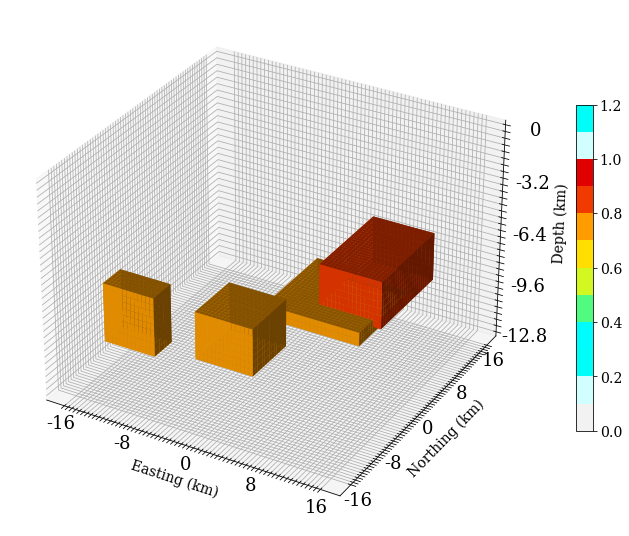

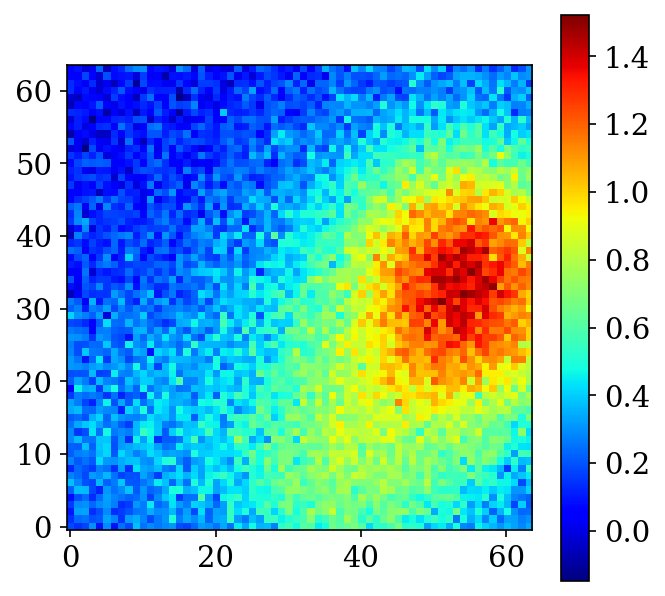

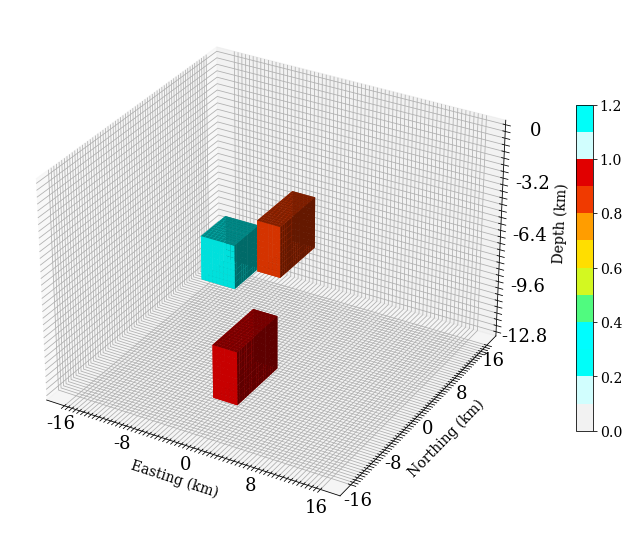

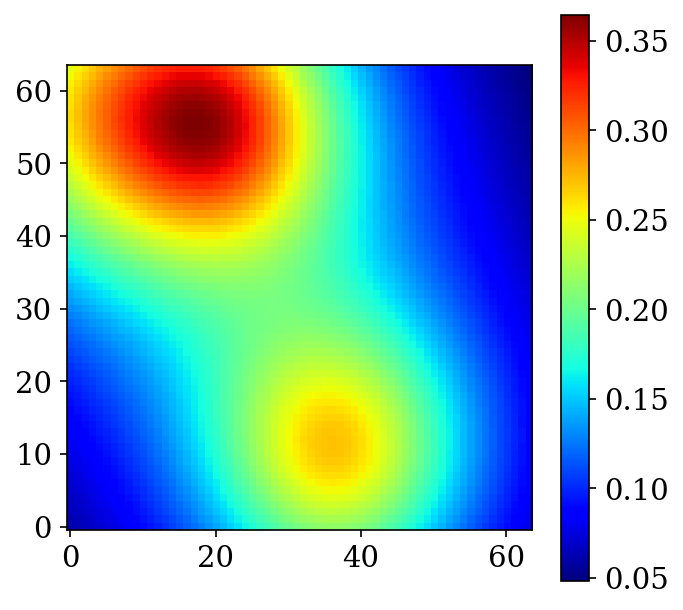

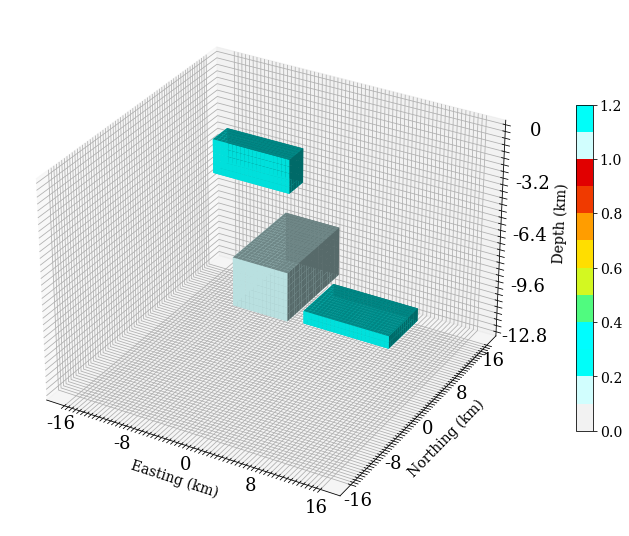

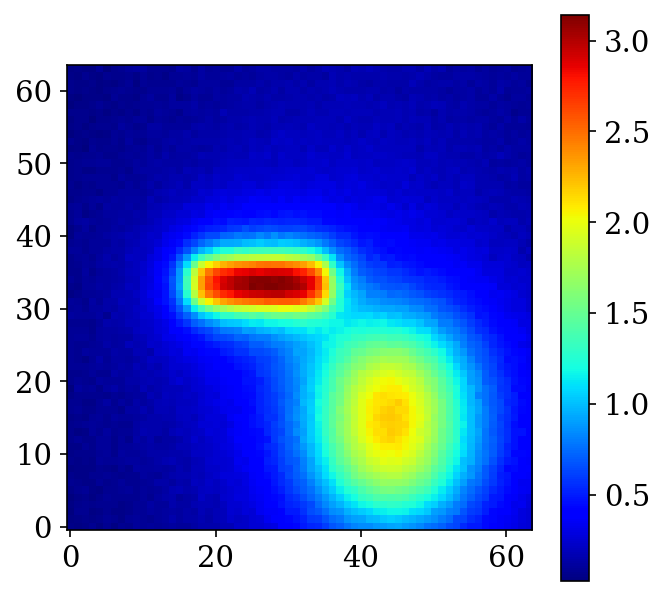

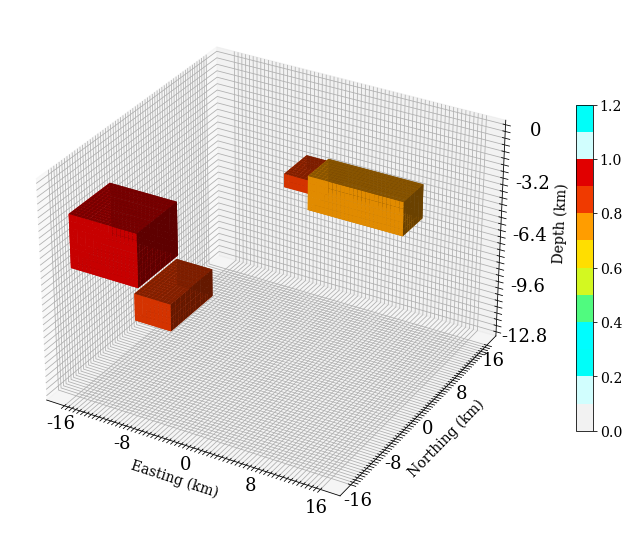

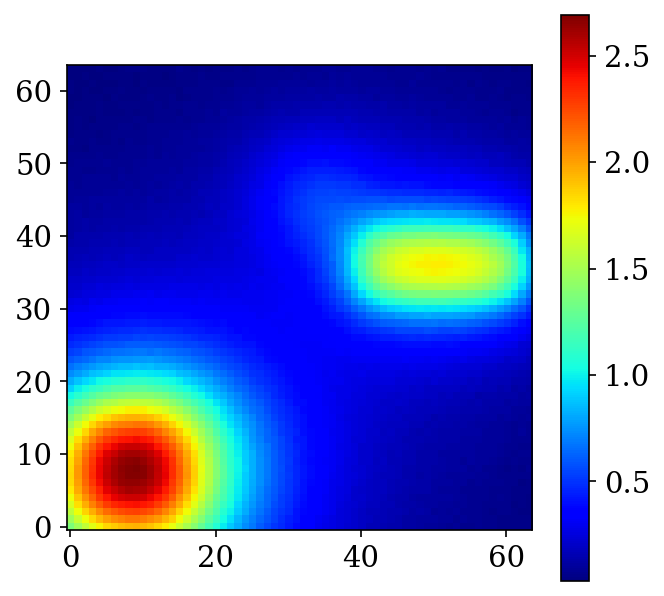

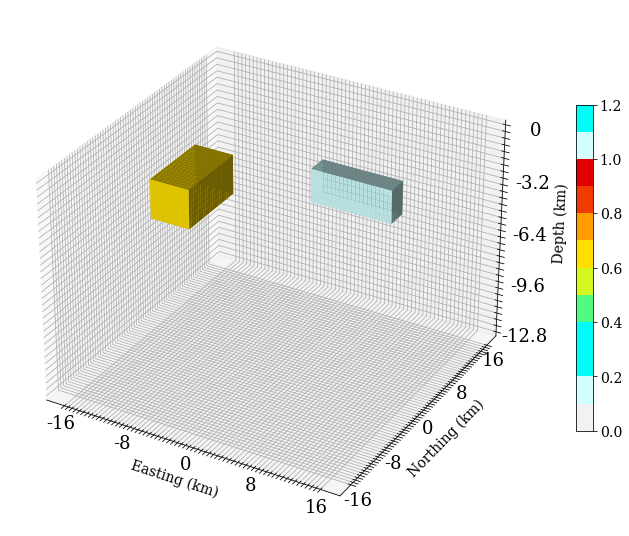

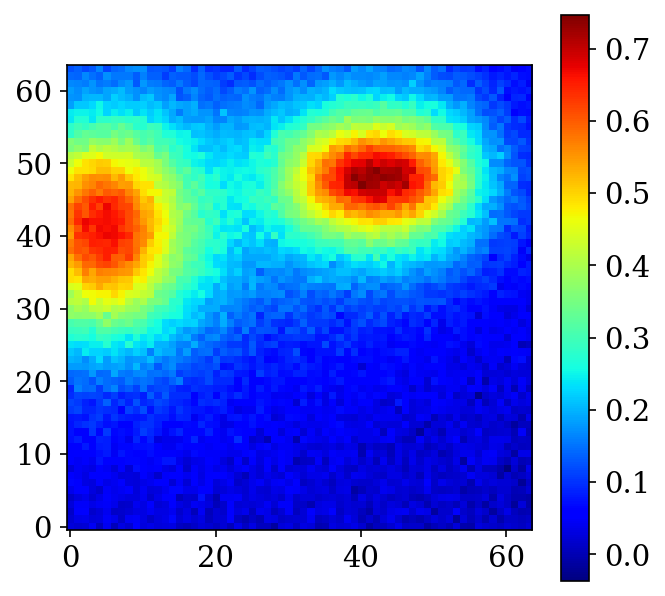

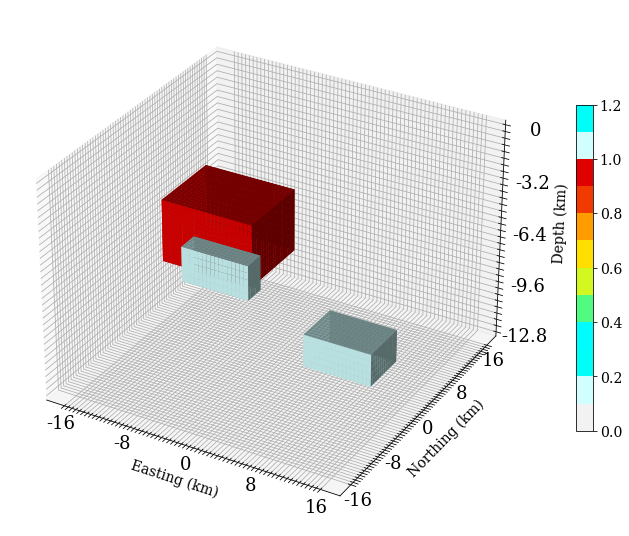

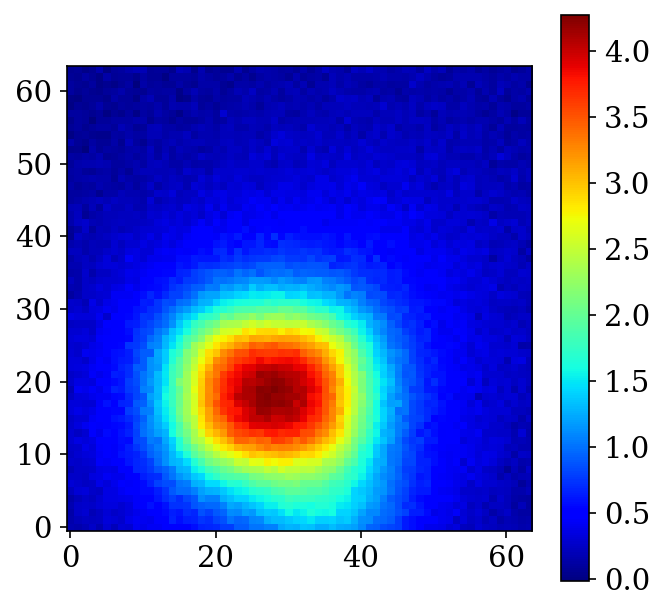

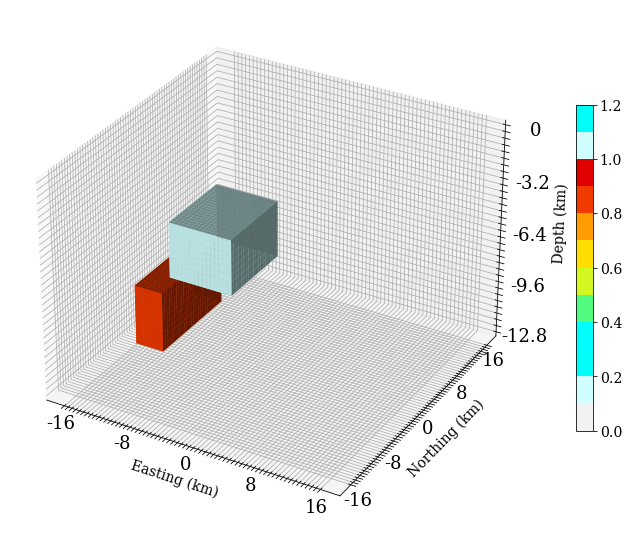

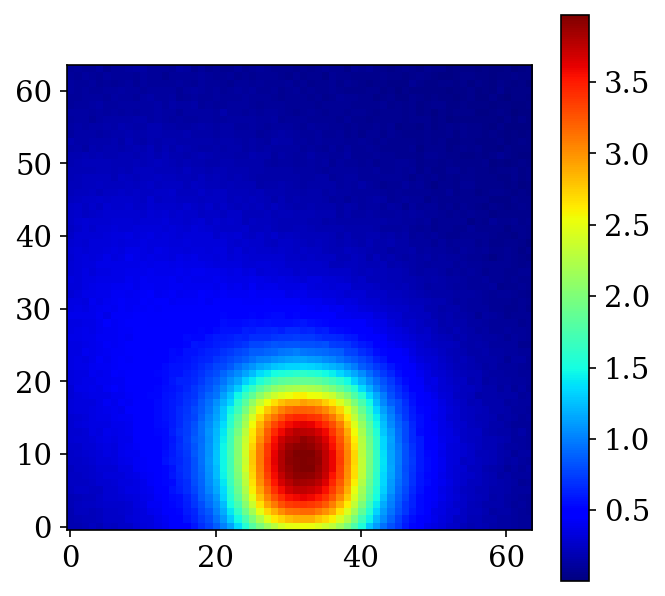

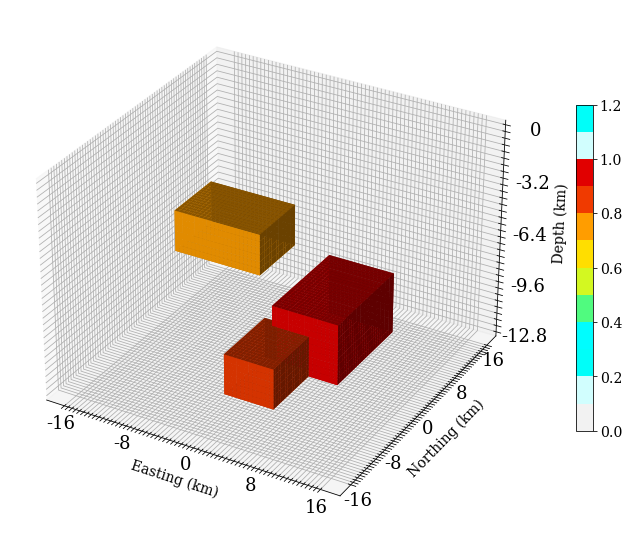

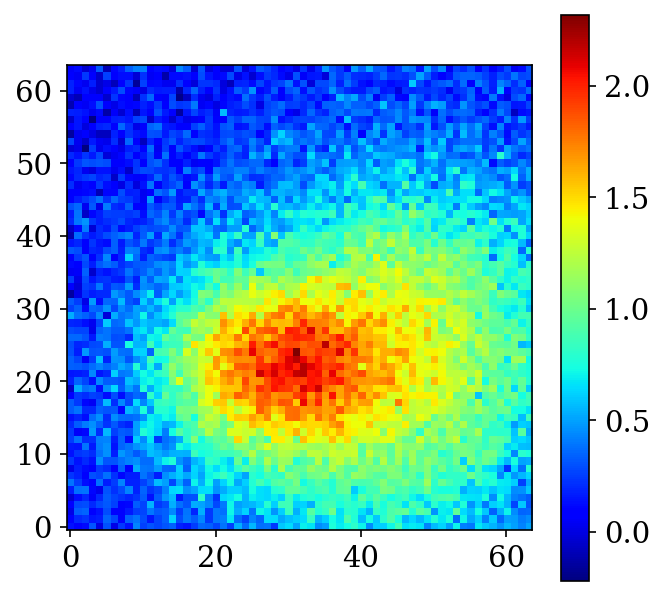

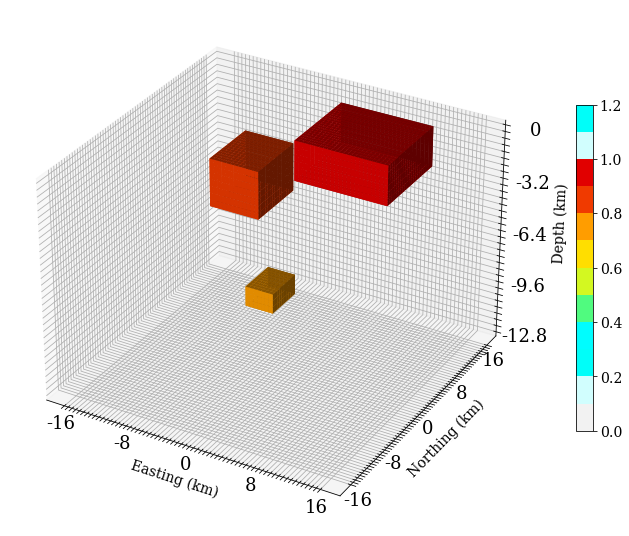

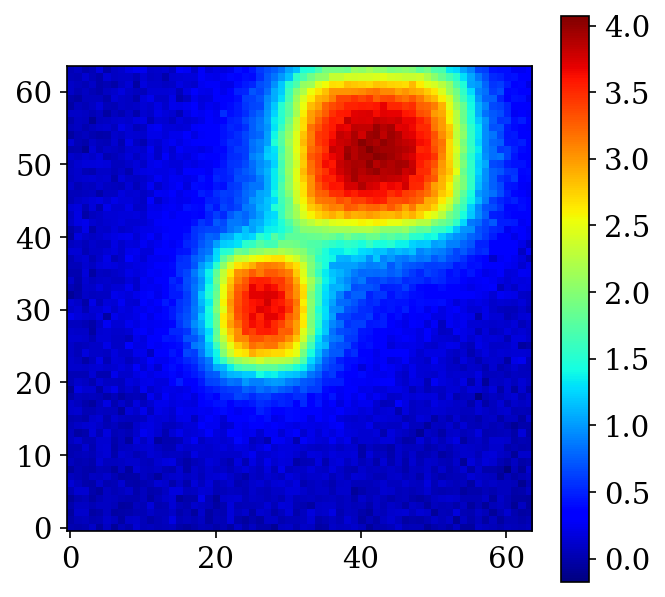

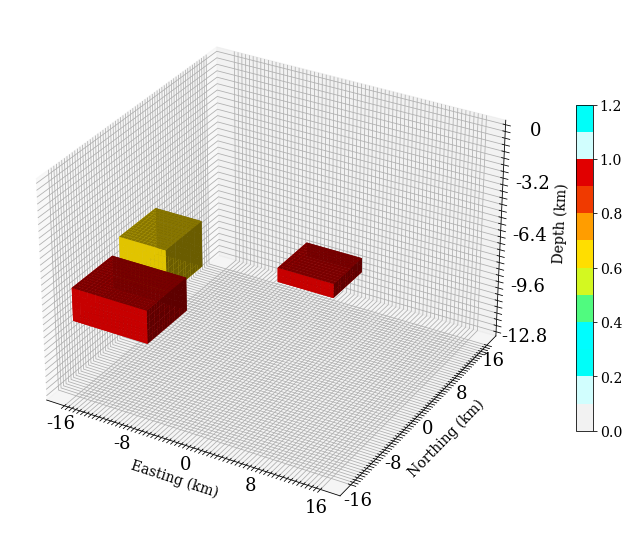

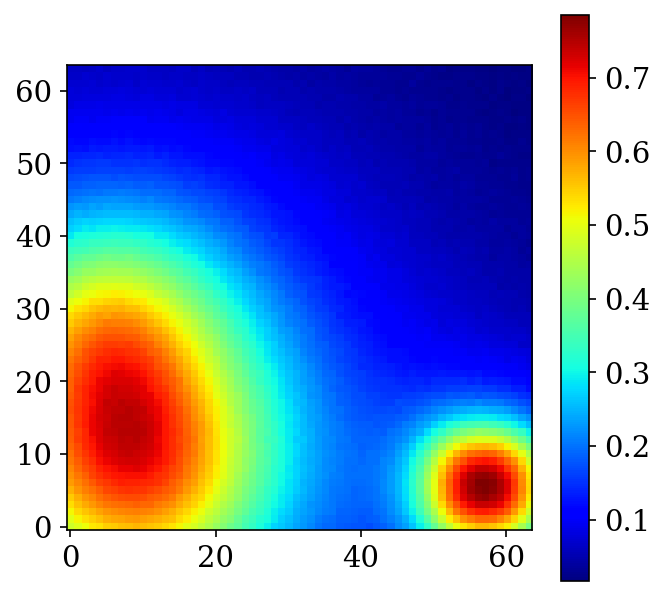

In [13]:
data_length = 40
for i in range(10):
    index = np.random.choice(data_length)
    modeltest = 'model{}.npy'.format(str(index+1))
    testfile = os.path.join(os.getcwd(), 'train_25_25_25', "models", modeltest)
    density = np.load(testfile)
    filename = str(index)+"density" 
    tru_model = density
    Model(tru_model, 0.01, filename = filename)

    gravtest = 'field{}.npy'.format(str(index+1))
    gravfile = os.path.join(os.getcwd(), 'train_25_25_25', "fields", gravtest)
    field = np.load(gravfile)

    filedimag(field)

In [5]:
data_length = 2000
DA = data_get.DensityDataset()
DaGet = GravDecoder()
DaGet.gen_kernel_eigs()
for i in range(data_length):
    density = DA.data()
    field = DaGet.forward(data_input = density)

    modelname = 'model{}.npy'.format(str(i+1))
    modelpath = os.path.join(os.getcwd(), 'verdatasets_withnoise', "models", modelname)
    np.save(modelpath, np.array(density))

    noise_level = np.random.choice([0, 0, 0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.015, 0.02, 0.04, 0.06])
    field = field.numpy().flatten()
    field = giutils.contaminate(field, noise_level, percent = True, seed = 62)
    
    fieldname = 'field{}.npy'.format(str(i+1))
    fieldpath = os.path.join(os.getcwd(), 'verdatasets_withnoise', "fields", fieldname)
    np.save(fieldpath, np.array(field.reshape(64 ,64)))
    if i % 500 == 0:
        print(i)

0
500
1000
1500
